# 指数基本信息

- 作者：DGC'Idea
- 版本：V0.3   
- 更新日期：2018年2月4日

----------

1. 基本信息：指数发布日期、编制机构、编制方法等信息；
2. PE信息：指数PE最新值、百分位，各重要百分位点，PE折线图；
3. PB信息：指数PB最新值、百分位，各重要百分位点，PE折线图；
4. 财务信息：指数最近四个季度的营收、利润、净资产；
5. 行情信息：指数最新收盘、开盘价、成交额等；
6. 成份股信息：指数十大成份股信息；
7. 对应基金信息：指数对应的优质基金信息。

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta,date
from jqdata import jy
import math
import matplotlib.pyplot as plt

#引入自定义库
import sys
sys.path.append('/home/jquser')
from tl import Code
from pf_idx import *
from pf_fnd import *

index=Index('csv','../Data/')
fund=Fund('csv','../Data/','index')

数据引擎：运行于研究
指数框架：运行于研究
基金框架：运行于研究


In [17]:
#==================================================================================================================
# 聚源常量
#------------------------------------------------------------------------------------------------------------------

#获取聚源常量、查询CT_SystemConst表
def get_jydata_const(const_type):
    df=pd.DataFrame()
    #因jy每次最多返回3000条数据，所以要多次查询
    #偏移值
    offset=0    
    while True:
        q=query(
            #内部代码
            jy.CT_SystemConst.DM,
            #常量值
            jy.CT_SystemConst.MS,
        ).filter(
            #按照类别查询
            jy.CT_SystemConst.LB==const_type,
        #偏移         
        ).offset(offset)
        #查询    
        temp_df=jy.run_query(q)  
        if len(temp_df)==0:
            break
        #追加数据
        df=df.append(temp_df)
        #偏移值每次递增3000    
        offset+=3000
    #按照DM索引
    df.index=df['DM']
    #返回字典
    return df['MS'].to_dict()

#指数成份股权重
WAMethod_const=get_jydata_const(1265)
#指数类别常量
IndexType_const=get_jydata_const(1266)
#指数调整周期常量
ComponentAdPeriod_const=get_jydata_const(1264)
#证券市场常量
SecuMarket_const=get_jydata_const(201)
#板块常量
ListedSector_const=get_jydata_const(207)

   



#==================================================================================================================
# 成份股信息
#------------------------------------------------------------------------------------------------------------------

# 获取股票市值
# InnerCode_list：内部代码列表
# 返回数据表
def get_stock_valuation(InnerCode_list):
    df=pd.DataFrame()
    #因jy每次最多返回3000条数据，所以要多次查询
    today=date.today()
    #偏移值
    offset=0    
    while True:
        q=query(
            #内部代码
            jy.LC_DIndicesForValuation.InnerCode,
            #流通市值
            jy.LC_DIndicesForValuation.NegotiableMV,
        ).filter(
            #按照内部代码、交易日查询
            jy.LC_DIndicesForValuation.InnerCode.in_(InnerCode_list),
            jy.LC_DIndicesForValuation.TradingDay==today,
        ).offset(
            #偏移  
            offset
        )
        temp_df=jy.run_query(q)  
        if len(temp_df)==0:
            break
        #追加数据
        df=df.append(temp_df)
        #偏移值每次递增3000    
        offset+=3000  
    if len(df)!=0:
        #按照内部代码索引
        df.index=df['InnerCode']
        del df['InnerCode']
        df.index.name=None
        #排序
        df.sort_index()
        #市值按照亿换算
        df.NegotiableMV=df.NegotiableMV/100000000.0
        #返回数据表
        return df
    else:
        return None


# 获取股票简称、证券代码、内部代码、证券市场
# InnerCode_list：内部代码列表
# 返回数据表
def get_stock_info(InnerCode_list):
    df=pd.DataFrame()
    #因jy每次最多返回3000条数据，所以要多次查询
    #偏移值
    offset=0    
    while True:
        q=query(
            #内部代码
            jy.SecuMain.InnerCode,
            #证券代码
            jy.SecuMain.SecuCode,
            #证券简称
            jy.SecuMain.SecuAbbr,
            #证券市场
            jy.SecuMain.SecuMarket,
        ).filter(
            #限定为股票查询
            jy.SecuMain.SecuCategory==1,
            #按照聚源内部代码查询
            jy.SecuMain.InnerCode.in_(InnerCode_list)
        ).offset(
            #偏移  
            offset
        )
        temp_df=jy.run_query(q)  
        if len(temp_df)==0:
            break
        #追加数据
        df=df.append(temp_df)
        #偏移值每次递增3000    
        offset+=3000  
    #按照内部代码索引
    df.index=df['InnerCode']
    del df['InnerCode']
    df.index.name=None
    #排序
    df.sort_index()
    #证券市场
    for i in range(len(df)):        
        df['SecuMarket'].iloc[i]=SecuMarket_const[df['SecuMarket'].iloc[i]][0:2]
    #返回数据表
    return df


# 获取股票所属行业
# InnerCode_list：内部代码列表
# 返回数据表
def get_stock_industry(InnerCode_list):
    #因所属行业随时间改动，此表包括了所有时间的改动信息，所以返回的数据超过3000行
    #先找到最近的改动日期，再查询
    q=query(
        jy.LC_CSIIndustry.EndDate
    ).filter(
        jy.LC_CSIIndustry.InnerCode==InnerCode_list[0],
    )
    df=jy.run_query(q)    
    #找到最近改动日期
    EndDate=max(df['EndDate'])
    df=pd.DataFrame()
    #因jy每次最多返回3000条数据，所以要多次查询
    #偏移值
    offset=0    
    while True:
        q=query(
            #内部代码
            jy.LC_CSIIndustry.InnerCode,
            #行业
            jy.LC_CSIIndustry.FstIndNameCSI,
        ).filter(
            #按照内部代码查询
            jy.LC_CSIIndustry.InnerCode.in_(InnerCode_list),
            #按照最后更改日期查找
            jy.LC_CSIIndustry.EndDate==EndDate
        ).offset(
            #偏移  
            offset
        )
        temp_df=jy.run_query(q)  
        if len(temp_df)==0:
            break
        #追加数据
        df=df.append(temp_df)
        #偏移值每次递增3000    
        offset+=3000  
    #按照内部代码索引
    df.index=df['InnerCode']
    del df['InnerCode']
    df.index.name=None
    #排序
    df.sort_index()
    #返回数据表
    return df



#==================================================================================================================
# 指数信息
#------------------------------------------------------------------------------------------------------------------


# 获取指数流通市值
def get_index_cmc(index_code):
    # 截至最近一个交易日
    end_date=pd.datetime.today()   
    # 获取当前所有成份股   
    stocks=get_index_stocks(index_code,end_date)
    q = query(
        valuation.market_cap,
        valuation.circulating_market_cap,
    ).filter(
        valuation.code.in_(stocks)
    )       
    df=get_fundamentals(q,end_date)
    # 单位：亿
    return round(df.circulating_market_cap.sum(),2)


# 获取指数基本信息
# code：证券代码
def get_index_info(code):
    q=query(
        #内部代码
        jy.LC_IndexBasicInfo.IndexCode,
        #类别
        jy.LC_IndexBasicInfo.IndexType,
        #编制机构
        jy.LC_IndexBasicInfo.CreatIndexOrgName,
        #权重方式
        jy.LC_IndexBasicInfo.WAMethod,
        #发布日期
        jy.LC_IndexBasicInfo.PubDate,
        #基准日期
        jy.LC_IndexBasicInfo.BaseDate,
        #基准点位
        jy.LC_IndexBasicInfo.BasePoint,
        #成份股数量
        jy.LC_IndexBasicInfo.ComponentSum,
        #调整日期
        jy.LC_IndexBasicInfo.ComponentAdPeriod,
        #简要说明
        jy.LC_IndexBasicInfo.IndexAbstract,   
    ).filter(
        #按照内部代码查询
        jy.LC_IndexBasicInfo.IndexCode==code
    )
    #查询LC_IndexBasicInfo表
    df=jy.run_query(q)
    #返回数据表
    return df


# 获取指数成份股及权重
# code：聚源内部代码
def get_index_stock(code):
    # 查询LC_IndexComponentsWeight表
    # 先获取最后更改日期
    q=query(
        jy.LC_IndexComponentsWeight.EndDate
    ).filter(
        jy.LC_IndexComponentsWeight.IndexCode==code,
    )
    df=jy.run_query(q)
    # 最后更改日期
    EndDate=max(df['EndDate'])
    # 按照最后更改日期查询
    df=pd.DataFrame()
    #因jy每次最多返回3000条数据，所以要多次查询
    #偏移值
    offset=0    
    while True:
        q=query(
            #内部代码
            jy.LC_IndexComponentsWeight.InnerCode,
            #权重
            jy.LC_IndexComponentsWeight.Weight,
        ).filter(
            #按照内部代码及最后日期查询
            jy.LC_IndexComponentsWeight.IndexCode==code,
            jy.LC_IndexComponentsWeight.EndDate==EndDate
        ).offset(
            #偏移  
            offset
        )
        temp_df=jy.run_query(q)  
        if len(temp_df)==0:
            break
        #追加数据
        df=df.append(temp_df)
        #偏移值每次递增3000    
        offset+=3000    
    df.index=df['InnerCode']
    del df['InnerCode']
    df.index.name=None
    #排序
    df.sort_index()
    return df


# 获取指数行情  
# code：聚源内部代码
# count：天数
def get_index_market(code,count=5):
    q=query(
        #交易日
        jy.QT_IndexQuote.TradingDay,
        #收盘价
        jy.QT_IndexQuote.ClosePrice,
        #涨幅
        jy.QT_IndexQuote.ChangePCT,
        #开盘价
        jy.QT_IndexQuote.OpenPrice,
        #最高价
        jy.QT_IndexQuote.HighPrice,
        #最低价
        jy.QT_IndexQuote.LowPrice,
        #昨日收盘价
        jy.QT_IndexQuote.PrevClosePrice,  
        #成交量
        jy.QT_IndexQuote.TurnoverVolume,
        #成交额
        jy.QT_IndexQuote.TurnoverValue,
        #流通市值
        jy.QT_IndexQuote.NegotiableMV,
    ).filter(
        #按照内部代码查询
        jy.QT_IndexQuote.InnerCode==code,
    ).order_by(
        #按证交易日降序排列
        jy.QT_IndexQuote.TradingDay.desc()
        #查询最近5个交易日
    ).limit(count)
    #查询QT_IndexQuote表
    df=jy.run_query(q)
    # 按照交易日索引
    df.index=df.TradingDay
    df.index.name=None
    del df['TradingDay']
    #返回数据表
    return df


# 获取指数财务指标  
# code：聚宽代码
def get_index_finance(code):
    date_list=['2018-03-30','2017-12-30','2017-09-30','2017-06-30','2017-03-30']
    quarter_list=['2018q1','2017q4','2017q3','2017q2','2017q1']
    data_list=[]
    #code=Code.secu_to_jq(code)
    #获取近五年财务信息
    for quarter,date in zip(quarter_list,date_list):
        stocks=get_index_stocks(code,date)
        q=query(
            income.code,
            income.total_operating_revenue,
            income.np_parent_company_owners,
            balance.total_assets,
            balance.total_liability
        ).filter(
            income.code.in_(stocks)
        )       
        df=get_fundamentals(q,statDate=quarter)
        yysr=round(sum(df.total_operating_revenue)/100000000.0,3)
        jlr=round(sum(df.np_parent_company_owners)/100000000.0,3)
        jzc=round((sum(df.total_assets)-sum(df.total_liability))/100000000.0,3)
        
        data_list.append([yysr,jlr,jzc])

    df=pd.DataFrame(index=quarter_list,data=data_list,columns=['营业收入','净利润','净资产'])
    return df.T


# 显示指数成份股  
# code：聚源内部代码
def show_index_stocks(code):
    df=pd.DataFrame()
    # 获取指数成份股内部代码列表
    df=get_index_stock(code)
    #按照内部代码拼接数据
    #基本信息
    info_df=get_stock_info(df.index)
    #行业信息
    industry_df=get_stock_industry(df.index)
    #财务信息
    valuation_df=get_stock_valuation(df.index)
    #拼接数据
    df=pd.concat([info_df,industry_df,valuation_df,df],axis=1)  
    #整理表                             
    df.index=df['SecuCode']  
    df.index.name=None
    del df['SecuCode'] 
    #按照权重降序排序
    df=df.sort(['Weight'],ascending=False)
    #更改标题
    df=df.rename(columns={'SecuAbbr':u'名称','SecuMarket':u'证券交易所',
                          'NegotiableMV':u'流通市值(亿)',
                          'Weight':u'权重%','FstIndNameCSI':u'所属行业'})
    return df


# 显示指数行情  
# code：聚源内部代码
def show_index_market(code):
    df=get_index_market(code)
    #成交量换算为万手
    df.TurnoverVolume=np.round(df.TurnoverVolume/1000000.0,3)
    #成交额、流通市值换算为亿
    df.TurnoverValue=np.round(df.TurnoverValue/100000000.0,3)
    df.NegotiableMV=df.NegotiableMV/100000000.0
    df=df.rename(columns={'TradingDay':'日期','PrevClosePrice':'昨收','OpenPrice':'开盘','HighPrice':'最高',
                          'LowPrice':'最低','ClosePrice':'今收','TurnoverVolume':'成交量(万手)','TurnoverValue':'成交额(亿元)',
                          'ChangePCT':'涨跌幅(%)','NegotiableMV':'流通市值(亿元)'
                         })
    return df


# 显示指数基本信息  
# code：聚源内部代码
def show_index_info(code):  
    # 字段名
    col_label=['说明']
    # 项目
    row_labels=['指数代码','指数名称','指数类别','编制机构','权重方法','发布日期','基准日期','基准点位','成份股数','调整周期',
                '简要说明','流通市值']
    info_df=pd.DataFrame(index=row_labels,columns=col_label)
    #获取基本信息
    df=get_index_info(code)
    #证券代码
    info_df.iloc[0,0]=index_code
    #中文名称
    info_df.iloc[1,0]=index_name
    #证券类别   
    info_df.iloc[2,0]=IndexType_const[int(df['IndexType'].iloc[0])] if not math.isnan(df['IndexType'].iloc[0]) else ''
    #编制机构   
    info_df.iloc[3,0]=df['CreatIndexOrgName'].iloc[0]
    #权重方法
    info_df.iloc[4,0]=WAMethod_const[int(df['WAMethod'].iloc[0])] if not math.isnan(df['WAMethod'].iloc[0]) else ''
    #发布日期  
    info_df.iloc[5,0]=str(df['PubDate'].iloc[0])[0:10]
    #基日
    info_df.iloc[6,0]=str(df['BaseDate'].iloc[0])[0:10]
    #基点
    info_df.iloc[7,0]=df['BasePoint'].iloc[0]
    #成份股数量   
    info_df.iloc[8,0]=df['ComponentSum'].iloc[0]
    #调整周期   
    info_df.iloc[9,0]=ComponentAdPeriod_const[int(df['ComponentAdPeriod'].iloc[0])] if not math.isnan(df['ComponentAdPeriod'].iloc[0]) else ''
    #简要说明
    info_df.iloc[10,0]=df['IndexAbstract'].iloc[0]
    #流通市值
    info_df.iloc[11,0]='%.2f亿'%(get_index_cmc(jq_code))
    #返回数据表
    return info_df


# 显示指数PE表
# code：聚宽代码
def show_index_pe(code):
    df=index.value.read(10)
#     df.index=df.index.astype('str').str[0:6] 
    df=df[df.index == code]
    #去除代码后缀

    df=df[['name','pe_e','pe_e_ratio','pe_e_state',
           'pe_e_min','pe_e_max','pe_e_median','pe_e_drop',
           'pe_e_q10','pe_e_q20','pe_e_q40','pe_e_q60','pe_e_q80','pe_e_q90']]
    df=df.rename(columns={'name':'名称','pe_e':'PE(等权)','pe_e_ratio':'高度','pe_e_state':'区间',
                'pe_e_min':'最低值','pe_e_max':'最高值','pe_e_median':'中位值','pe_e_drop':'距底',
                'pe_e_q10':'10%值','pe_e_q20':'20%值','pe_e_q40':'40%值','pe_e_q60':'60%值',
                'pe_e_q80':'80%值','pe_e_q90':'90%值',}) 
    return df 


# 显示指数PB表
# code：聚宽代码
def show_index_pb(code):
    df=index.value.read(10)
    df=df[df.index == code]
    df=df[['name','pb_e','pb_e_ratio','pb_e_state',
           'pb_e_min','pb_e_max','pb_e_median','pb_e_drop',
           'pe_e_q10','pe_e_q20','pe_e_q40','pe_e_q60','pe_e_q80','pe_e_q90']]
    df=df.rename(columns={'name':'名称','pb_e':'PB(等权)','pb_e_ratio':'高度','pb_e_state':'区间',
                'pb_e_min':'最低值','pb_e_max':'最高值','pb_e_median':'中位值','pb_e_drop':'距底',
                'pbs10':'10%值','pbs20':'20%值','pbs40':'40%值','pbs60':'60%值',
                'pe_e_q80':'80%值','pe_e_q90':'90%值',}) 
    return df 


#指数成份构成饼图
def pie_index_stock(df):   
    df=df.groupby(u'所属行业').sum()
    df=df[[u'权重%']]
    fig,ax=plt.subplots(figsize=(8,8))
    df.plot(kind='pie',ax=ax,subplots=True,fontsize=12)
    ax.set_title('指数构成（行业权重）',fontsize=14,alpha=0.9) 
    ax.set_ylabel('')  


#==================================================================================================================
# 基金信息
#------------------------------------------------------------------------------------------------------------------


#获取基金行情
def get_fund_price(codes):
    fund_list=Code.secu_to_jq(list(codes))
    #最近一个交易日
    end_date=pd.datetime.today()-timedelta(1)
    df=pd.DataFrame()
    #获取行情信息
    for code in fund_list:
        price_df=get_price(code,end_date=end_date,count=1,frequency='daily', 
                      fields=['close','low','high','open','pre_close','volume','money']) 
        df=pd.concat([df,price_df],axis=0)    
    #成交额、成交量换算单位
    df.volume=np.round(df.volume/1000000.0,3)
    df.money=np.round(df.money/10000.0,3)
    #计算涨跌、涨幅
    df['value']=np.round(df.close-df.pre_close,3)
    df['change']=np.round(df.value/df.close*100,3)    
    #插入最近交易日列
    df.insert(0,'trade-date',df.index.tolist())
    #按照代码索引
    df.index=codes
    #删除多余列
    del df['pre_close']
    #去除索引名
    df.index.name=None  

    return df


# 获取基金净值
def get_fund_extras(codes):
    fund_list=Code.secu_to_jq(list(codes))
    #最近一个交易日
    end_date=pd.datetime.today()#-timedelta(1)
    #获取单位净值
    unit_df=get_extras('unit_net_value',fund_list,end_date=end_date,count=1,df=True)
    unit_df=unit_df.T
    unit_df.columns=['unit_net_value']
    unit_df.index=codes
    #获取累计净值
    acc_df=get_extras('acc_net_value',fund_list,end_date=end_date,count=1,df=True)
    acc_df=acc_df.T
    acc_df.columns=['acc_net_value']
    acc_df.index=codes
    #返回数据表
    return unit_df,acc_df


# 获取指数对应的基金
# code：聚宽代码
def get_index_fund(code):
    #读取基金表
    df=fund.pool.show()
    #查询当前指数所有基金
    df=df[df['index_code']==code]
    if len(df)==0:
        return None
    else: 
        #重新索引
#         df.index=df.fund_code
#         del df['fund_code']
#         df.index.name=None
        #重新排序
        df.sort_index()
        #删除多余的列
        del df['index_name']
        del df['index_code']
        return df
    

#显示指数对应的基金
# code：聚宽代码
def show_index_fund(code):
    #获取指数关联基金
    df=get_index_fund(code)
    if len(df)==0:
        print '无对应基金！'
        return

    #获取基金行情
    price_df=get_fund_price(df.index) 
    #获取基金净值
    unit_df,acc_df=get_fund_extras(df.index) 
    #组织数据
    df=pd.concat([df,price_df,unit_df,acc_df],axis=1)  
    #去除代码后缀
    #df.index=df.index.str[0:6]
    #重命名标题
    df=df.rename(columns={
            'name':'基金名称','start_date':'成立日期','type':'类别',
            #'pre_close':'昨收',
            'open':'开盘','high':'最高',
            'low':'最低','close':'收盘','volume':'成交量(万)','money':'成交额(万)',
            'change':'涨跌幅(%)','value':'涨跌额',
            'trade-date':'最近交易日','unit_net_value':'单位净值','acc_net_value':'累计净值'
            })
    return df



#显示当前指数提示
def show_index_title(title):
    print '指数：%s %s %s'%(index_code,index_name,title)

## 当前指数

In [9]:
#证券代码
index_code='000300.SH'
#聚宽代码
jq_code=Code.secu_to_jq(index_code)
#聚源内部代码
jy_code=Code.idx_to_jy(index_code)
#指数名称
index_name=index.pool.name(index_code)

show_index_title('')

指数：000300.SH 沪深300 


## 1.基本信息
- 指数发布日期、编制机构、编制方法等信息。

In [10]:
#指数基本信息
show_index_title('基本信息一览')
pd.set_option('max_colwidth', 100)
df=show_index_info(jy_code)
df

指数：000300.SH 沪深300 基本信息一览


,说明
指数代码,000300.SH
指数名称,沪深300
指数类别,规模类指数
编制机构,中证指数有限公司
权重方法,流通股比例分级靠档加权
发布日期,2005-04-08
基准日期,2004-12-31
基准点位,1000
成份股数,300
调整周期,半年


## 2.PE
- 指数PE最新值、百分位，各重要百分位点，PE折线图。

指数：000300.SH 沪深300 PE估值、走势图、频谱图


,名称,PE(等权),高度,区间,最低值,最高值,中位值,距底,10%值,20%值,40%值,60%值,80%值,90%值
000300.SH,沪深300,15.16,5.43,极低,11.69,44.42,20.92,-22.89,15.69,16.78,19.33,22.34,24.47,33.46


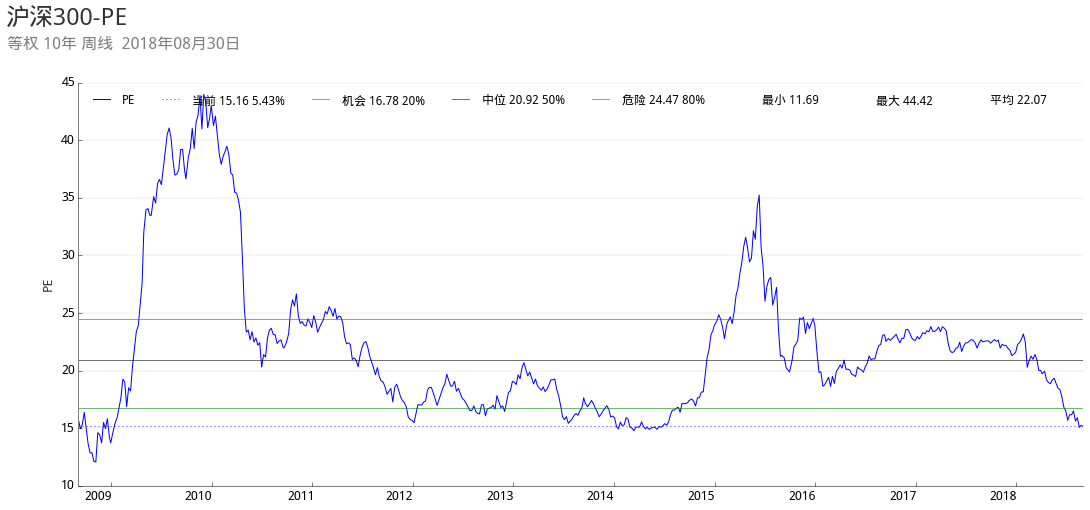

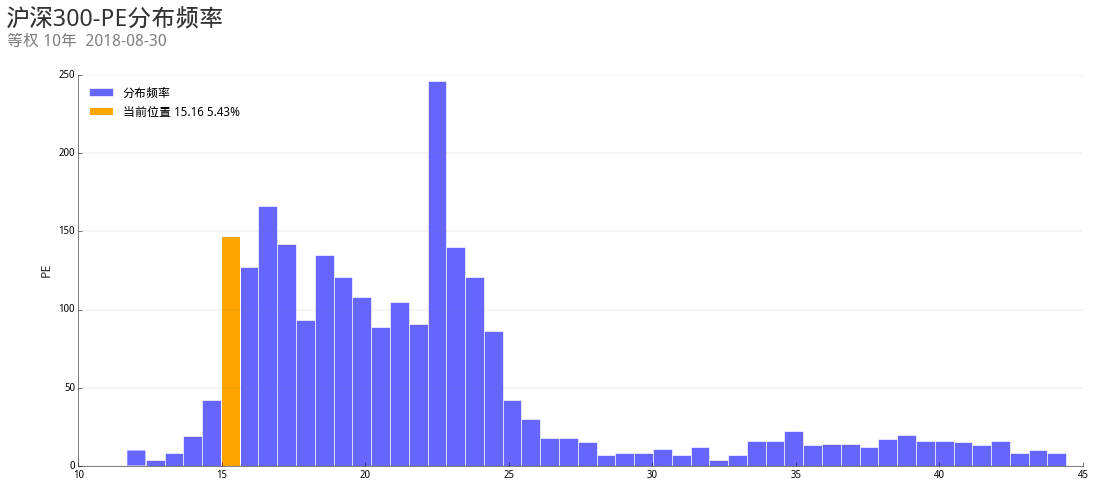

In [11]:
#指数PE信息（PE分位值、走势图、频谱图）
show_index_title('PE估值、走势图、频谱图')
index.value.chart.line_one(index_code,item='pe',mode='e')
index.value.chart.hist(index_code,item='pe',mode='e')
df=show_index_pe(index_code)
df

## 3.PB
- 指数PB最新值、百分位，各重要百分位点，PE折线图。

指数：000300.SH 沪深300 PB估值、走势图、频谱图


,名称,PB(等权),高度,区间,最低值,最高值,中位值,距底,pe_e_q10,pe_e_q20,pe_e_q40,pe_e_q60,80%值,90%值
000300.SH,沪深300,1.68,8.34,极低,1.51,4.07,2.22,-10.12,15.69,16.78,19.33,22.34,24.47,33.46


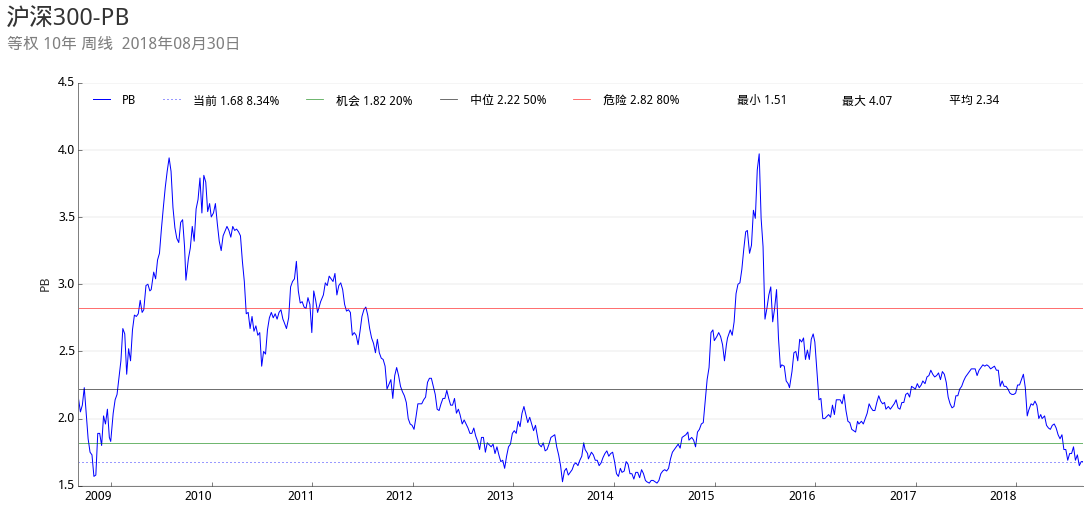

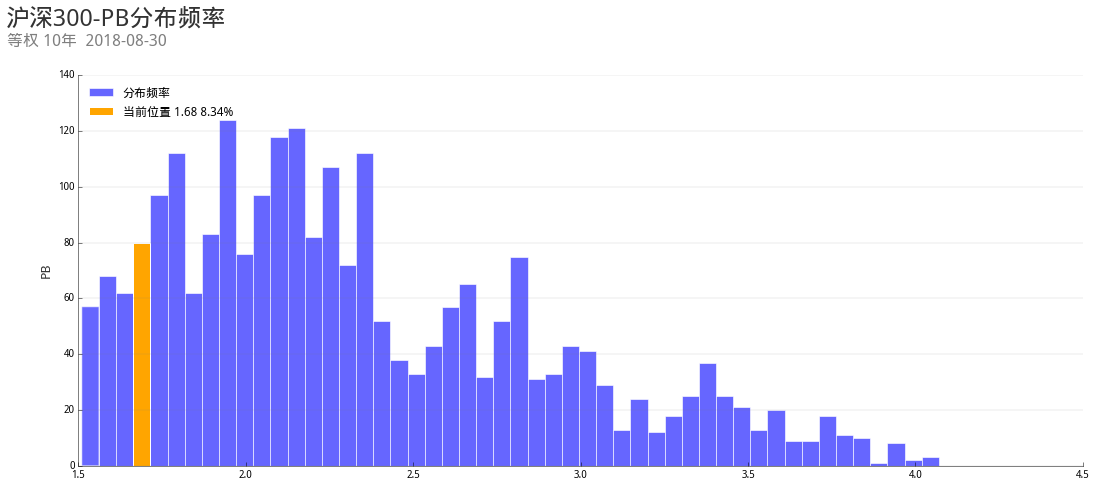

In [12]:
#指数PB信息（PB分位值、走势图、频谱图）
show_index_title('PB估值、走势图、频谱图')
index.value.chart.line_one(index_code,item='pb',mode='e')
index.value.chart.hist(index_code,item='pb',mode='e')
df=show_index_pb(index_code)
df

## 4.财务信息
- 指数最近四个季度的营收、利润、净资产。

指数：000300.SH 沪深300 财务信息，ROE、股息率走势


,2018q1,2017q4,2017q3,2017q2,2017q1
营业收入,64503.077,70104.833,60113.298,59575.107,58051.779
净利润,7156.322,5738.446,6598.764,6718.365,6248.585
净资产,253972.599,247509.643,234805.959,226848.522,223225.623


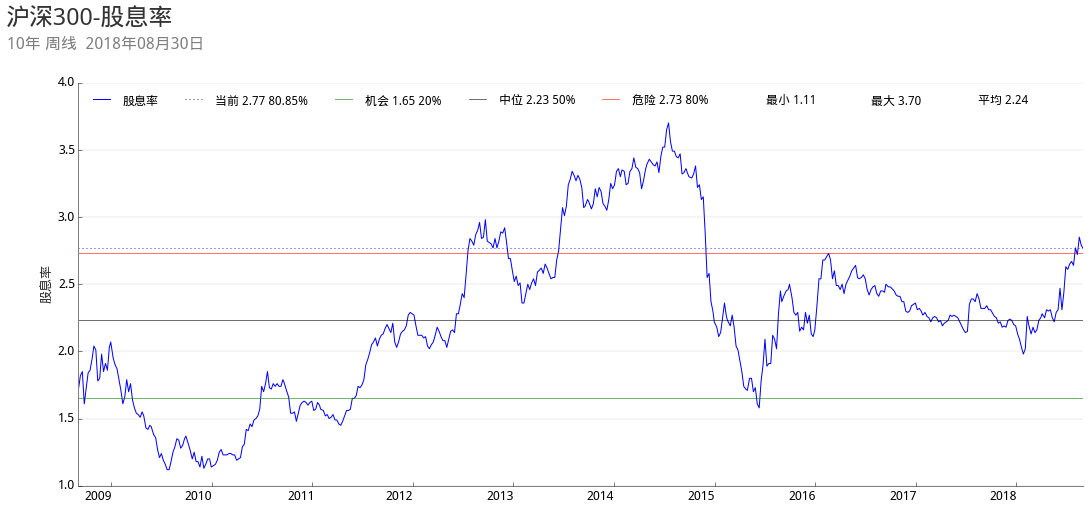

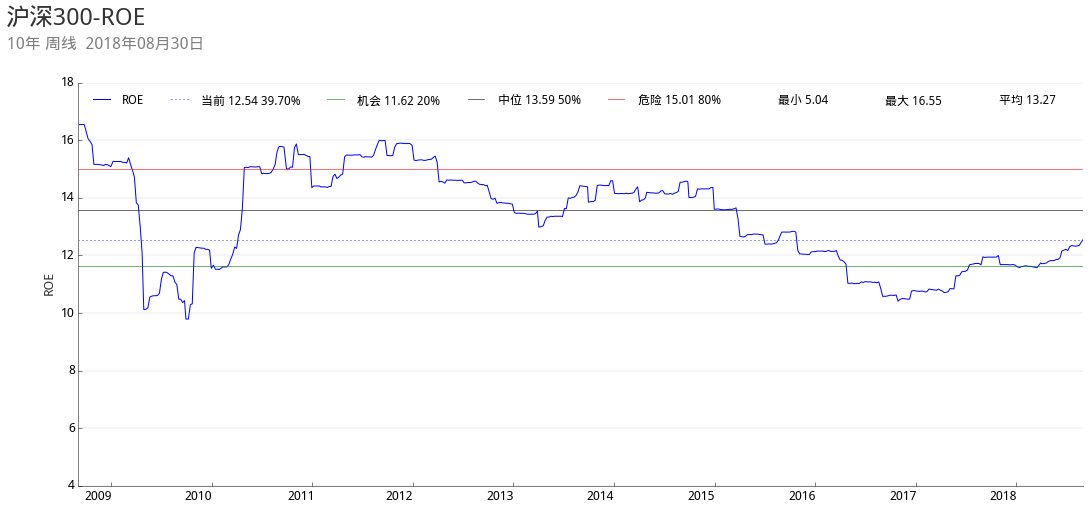

In [18]:
show_index_title('财务信息，ROE、股息率走势')
#指数ROE、股息率走势
index.value.chart.line_one(index_code,item='dyr',mode='')
index.value.chart.line_one(index_code,item='roe',mode='')
#指数财务信息
df=get_index_finance(jq_code)
df

## 5.行情信息
- 指数最新收盘、开盘价、成交额等。

In [14]:
#获取指数行情信息（价格走势图）
show_index_title('行情信息')
df=show_index_market(jy_code)
df

指数：000300.SH 沪深300 行情信息


,今收,涨跌幅(%),开盘,最高,最低,昨收,成交量(万手),成交额(亿元),流通市值(亿元)
2018-08-31,3334.5036,-0.495080,3333.3801,3356.5757,3310.8726,3351.0942,7620.563,960.919,101451.1183
2018-08-30,3351.0942,-1.047649,3385.8052,3402.5626,3349.4688,3386.5736,6838.529,802.261,101955.8805
2018-08-29,3386.5736,-0.399889,3393.0527,3398.7139,3377.1231,3400.1705,6702.040,790.723,103035.3287
2018-08-28,3400.1705,-0.187960,3408.1502,3416.5929,3388.8143,3406.5735,7544.536,949.459,103449.0091
2018-08-27,3406.5735,2.443026,3339.3894,3406.5735,3339.2646,3325.3347,9427.008,1149.610,103643.8184


## 6.指数构成及成份股信息
- 指数十大成份股信息。

指数：000300.SH 沪深300 十大成份股、行业构成


/opt/conda/envs/python2/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,名称,证券交易所,所属行业,权重%
601318,中国平安,上海,金融地产,6.725
600519,贵州茅台,上海,主要消费,3.265
600036,招商银行,上海,金融地产,2.876
000333,美的集团,深圳,可选消费,1.891
601166,兴业银行,上海,金融地产,1.853
000651,格力电器,深圳,可选消费,1.848
600016,民生银行,上海,金融地产,1.669
601328,交通银行,上海,金融地产,1.522
600887,伊利股份,上海,主要消费,1.450
600276,恒瑞医药,上海,医药卫生,1.441


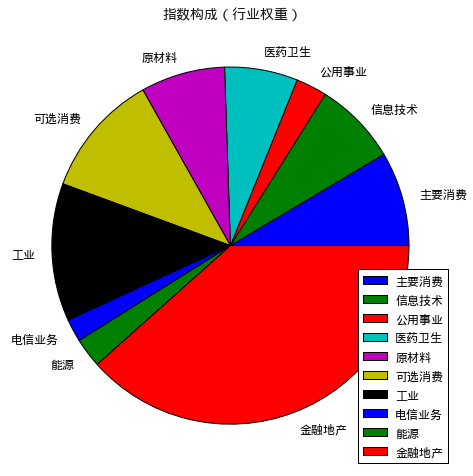

In [15]:
show_index_title('十大成份股、行业构成') 
df=show_index_stocks(jy_code)
pie_index_stock(df)
df[0:10]

## 7.关联基金
- 指数对应的优质基金信息。

In [16]:
#指数对应的基金信息
show_index_title('关联基金') 
df=show_index_fund(index_code)
df

指数：000300.SH 沪深300 关联基金


,名称,类别,start_date,最近交易日,收盘,最低,最高,开盘,成交量(万),成交额(万),涨跌额,涨跌幅(%),单位净值,累计净值
510360.SH,广发300,etf,2015-09-09,2018-08-31,1.066,1.060,1.075,1.068,16.062,1717.706,-0.008,-0.750,NaN,NaN
510300.SH,300ETF,etf,2012-05-28,2018-08-31,3.390,3.372,3.424,3.402,149.124,50622.312,-0.026,-0.767,NaN,NaN
160706.SZ,嘉实300,lof,2005-10-17,2018-08-31,0.955,0.951,0.963,0.961,3.329,318.049,-0.006,-0.628,0.961,2.852
167901.SZ,华宸300,lof,2013-06-03,2018-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166007.SZ,中欧300,lof,2010-08-16,2018-08-31,1.246,1.246,1.246,1.246,0.000,0.000,0.000,0.000,NaN,NaN
159919.SZ,300ETF,etf,2012-05-28,2018-08-31,3.686,3.671,3.721,3.710,11.429,4227.851,-0.035,-0.950,3.703,1.415
510310.SH,HS300ETF,etf,2013-03-25,2018-08-31,1.441,1.433,1.452,1.452,4.025,580.280,-0.014,-0.972,NaN,NaN
159925.SZ,南方300,etf,2013-04-11,2018-08-31,1.421,1.408,1.434,1.410,0.125,17.573,-0.002,-0.141,NaN,NaN
510390.SH,平安300,lof,2018-01-26,2018-08-31,3.411,3.365,3.411,3.400,3.184,1080.351,0.003,0.088,3.393,0.812
510330.SH,华夏300,etf,2013-01-16,2018-08-31,3.674,3.648,3.697,3.686,31.981,11745.554,-0.021,-0.572,NaN,NaN
